In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime, timedelta
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Reading the csv file and check for correlation scores
df = pd.read_csv("/content/drive/MyDrive/Data Warehousing/bank_transactions.csv")
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [3]:
# check missing values
df.isna().sum()

,0
TransactionID,0
CustomerID,0
CustomerDOB,3397
CustGender,1100
CustLocation,151
CustAccountBalance,2369
TransactionDate,0
TransactionTime,0
TransactionAmount (INR),0


In [4]:
#check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [5]:
#TASK A:
df = df.dropna(subset=["CustomerID", "TransactionAmount (INR)", "CustomerDOB", "TransactionDate"])
df = df[df["TransactionAmount (INR)"] > 0]

df["CustomerDOB"] = pd.to_datetime(df["CustomerDOB"], format="%d/%m/%y", errors="coerce")
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"], format="%d/%m/%y", errors="coerce")

df["Age"] = df["TransactionDate"].dt.year - df["CustomerDOB"].dt.year
df = df[(df["Age"] >= 18) & (df["Age"] <= 100)].copy()

df.loc[:, "CustLocation"] = df["CustLocation"].fillna("Unknown")
df.loc[:, "CustGender"] = df["CustGender"].fillna("Unknown")

top_locations = df["CustLocation"].value_counts().head(5)
print("Top 5 Locations where the maximum number of transactions occurred:")
print(top_locations)
top_locations.to_csv("top_locations.csv")

Top 5 Locations where the maximum number of transactions occurred:
CustLocation
MUMBAI       92404
BANGALORE    74432
NEW DELHI    70090
GURGAON      66844
DELHI        63576
Name: count, dtype: int64


In [6]:
conn = sqlite3.connect("RFM_SQL_DB.db")
df.to_sql("bank_data", conn, if_exists="replace", index=False)

query_rfm = '''
SELECT
    CustomerID,
    MAX(TransactionDate) AS last_order_date,
    COUNT(*) AS count_order,
    SUM("TransactionAmount (INR)") AS totalprice
FROM bank_data
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID
'''

In [7]:
rfm = pd.read_sql(query_rfm, conn)
rfm["last_order_date"] = pd.to_datetime(rfm["last_order_date"])
snapshot_date = rfm["last_order_date"].max() + timedelta(days=1)

In [8]:
rfm["Recency"] = (snapshot_date - rfm["last_order_date"]).dt.days
rfm.rename(columns={"count_order": "Frequency", "totalprice": "Monetary"}, inplace=True)
rfm = rfm[["CustomerID", "Recency", "Frequency", "Monetary"]]

print("=== RFM Table ===")
print(rfm.head())

print("RFM Distribution:")
print("Recency:", rfm["Recency"].describe())
print("Frequency:", rfm["Frequency"].describe())
print("Monetary:", rfm["Monetary"].describe())

=== RFM Table ===
  CustomerID  Recency  Frequency  Monetary
0   C1010011       26          2    5106.0
1   C1010012       69          1    1499.0
2   C1010014       76          2    1455.0
3   C1010018       37          1      30.0
4   C1010028       54          1     557.0
RFM Distribution:
Recency: count    799558.000000
mean         56.495703
std          15.223463
min           1.000000
25%          44.000000
50%          56.000000
75%          70.000000
max          82.000000
Name: Recency, dtype: float64
Frequency: count    799558.000000
mean          1.164531
std           0.421898
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: Frequency, dtype: float64
Monetary: count    7.995580e+05
mean     1.580087e+03
std      6.324977e+03
min      1.000000e-02
25%      1.890000e+02
50%      5.000000e+02
75%      1.321000e+03
max      1.560035e+06
Name: Monetary, dtype: float64


In [10]:
rfm_transformed = pd.DataFrame()
rfm_transformed["Recency"] = stats.boxcox(rfm["Recency"])[0]
rfm_transformed["Frequency"] = stats.boxcox(rfm["Frequency"])[0]
rfm_transformed["Monetary"] = stats.boxcox(rfm["Monetary"])[0]

print("Transformed RFM values")
print(rfm_transformed.head())

Transformed RFM values
      Recency  Frequency   Monetary
0   39.142967   0.109423  10.473246
1  126.146497   0.000000   8.703697
2  141.538091   0.109423   8.661921
3   59.876547   0.000000   3.683792
4   94.157970   0.000000   7.345916


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_transformed)

kmeans = KMeans(n_clusters=4, random_state=1)
rfm["Cluster"] = kmeans.fit_predict(X_scaled)
print("Final RFM with Clusters")
print(rfm.head())

print("Cluster Counts:")
print(rfm["Cluster"].value_counts())

rfm.to_csv("rfm_clusters.csv", index=False)

Final RFM with Clusters
  CustomerID  Recency  Frequency  Monetary  Cluster
0   C1010011       26          2    5106.0        3
1   C1010012       69          1    1499.0        0
2   C1010014       76          2    1455.0        3
3   C1010018       37          1      30.0        1
4   C1010028       54          1     557.0        1
Cluster Counts:
Cluster
1    271568
0    205901
2    205368
3    116721
Name: count, dtype: int64


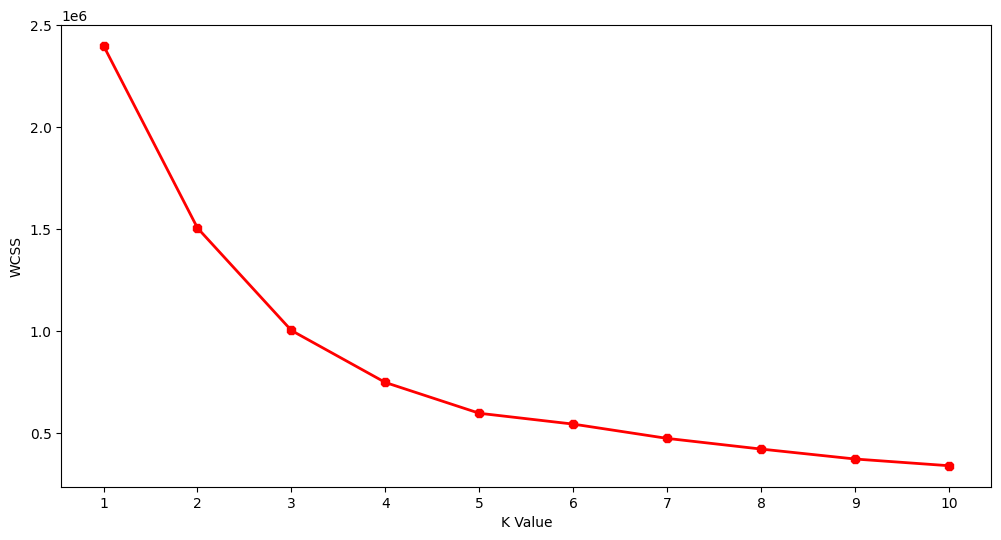

         Recency  Frequency  Monetary
Cluster                              
0          70.70       1.00   1411.25
1          44.87       1.00   1286.77
2          62.85       2.07   2746.76
3          40.86       2.16   3032.18
Cluster
0    342538
1    340283
3     75155
2     41582
Name: count, dtype: int64


In [12]:
#TASK B:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(1,11), wcss, linewidth=2, color="red", marker="8")
plt.xlabel("K Value")
plt.ylabel("WCSS")
plt.xticks(np.arange(1,11,1))
plt.show()

kmeans_final = KMeans(n_clusters=4, n_init='auto')
rfm["Cluster"] = kmeans_final.fit_predict(X_scaled)

cluster_profile = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().round(2)
print(cluster_profile)

print(rfm["Cluster"].value_counts())

rfm.to_csv("rfm_with_clusters.csv", index=False)